# Flowers Classfication

We a simple example to demonstrate how to use tensorflow datasets and tf2.3

@date: 01-Aug-2020 | @author: katnoria

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Input
from tensorflow.keras import Model

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [4]:
# Load the dataset
ds, info = tfds.load('tf_flowers', split='train', shuffle_files=True, with_info=True)

In [5]:
len(ds)

3670

Use the built in function to visualise the dataset 

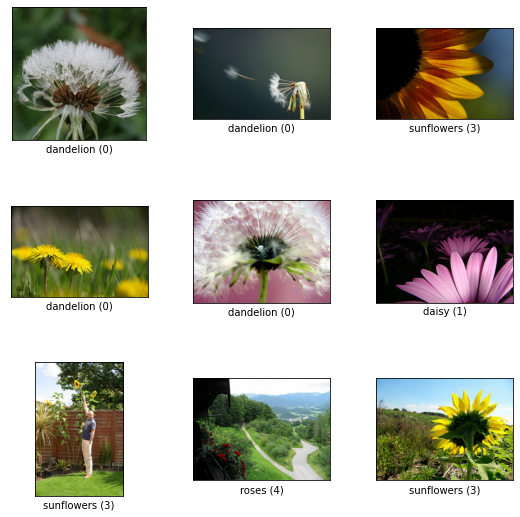

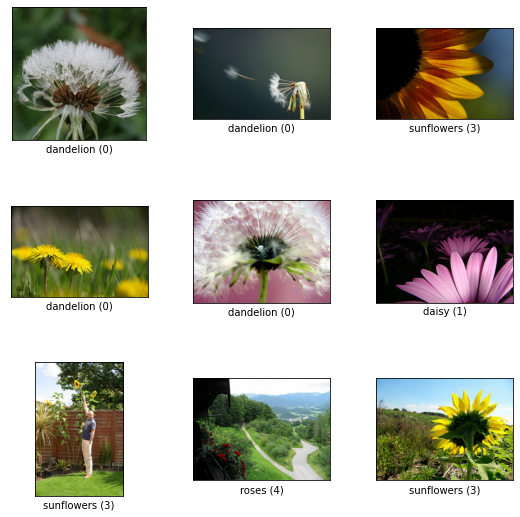

In [6]:
# Use the built-in 
tfds.show_examples(ds, info)

In [7]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [8]:
print(f"Number of classes: {info.features['label'].num_classes}")
print(f"Labels: {info.features['label'].names}")
print(f"Int label to Str: {info.features['label'].int2str(3)}")
print(f"Str label to Int: {info.features['label'].str2int('sunflowers')}")

Number of classes: 5
Labels: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Int label to Str: sunflowers
Str label to Int: 3


In [9]:
print(info.features['image'].shape)
print(info.features['image'].dtype)

(None, None, 3)
<dtype: 'uint8'>


In [10]:
print(info.splits)

{'train': <tfds.core.SplitInfo num_examples=3670>}


In [11]:
for example in ds.take(1):
    print(list(example.keys()))
    image = example['image']
    label = example['label']
    print(image.shape, label)

['image', 'label']
(240, 182, 3) tf.Tensor(1, shape=(), dtype=int64)


## Create Train and Test Splits

We now load the train and test splits and build the training pipeline. Flowers dataset does not provide train and test split so we will need to do it ourselves. And, that too is rather straightforward with the datasets library 🎉.

In [12]:
(ds_train, ds_test), info = tfds.load(
    'tf_flowers',
    split=[
        'train[:80%]',
        'train[-20%:]',        
    ],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 2936
Test dataset size: 734


In [13]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

### Training Pipeline

In [14]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64])
    return image / 255., label

In [15]:
train_ds = ds_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .shuffle(num_train_examples).batch(128) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [16]:
example = train_ds.take(1)

### Evaluation Pipeline

In [18]:
test_ds = ds_test.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .batch(128) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

# Build Model

We now build a simple convolution neural network

In [65]:
class FlowersModel(Model):
    def __init__(self):
        super(FlowersModel, self).__init__()
        self.conv1 = Conv2D(64, 3, padding='same')
#         self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(128, 3, padding='same')
#         self.bn2 = BatchNormalization()        
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(5)
        
    def call(self, x, training=False):
        x = self.conv1(x)
#         x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
#         x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.flatten(x)
        x = self.dense1(x)
        if training:
            x = tf.nn.dropout(x, rate=0.1)
        out = self.dense2(x)
        return out

In [66]:
model = FlowersModel()
first_batch = tf.zeros((1, 64, 64, 3))
model(first_batch)
model.summary()

Model: "flowers_model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           multiple                  1792      
_________________________________________________________________
conv2d_19 (Conv2D)           multiple                  73856     
_________________________________________________________________
flatten_9 (Flatten)          multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  67108992  
_________________________________________________________________
dense_20 (Dense)             multiple                  645       
Total params: 67,185,285
Trainable params: 67,185,285
Non-trainable params: 0
_________________________________________________________________


Create the loss function and optimizer

In [67]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

We are going to measure the train and test accuracy of the model

In [68]:
# Train
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')

# Test
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

We now train the model

In [69]:
# Training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    # collect the gradients and apply
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # loss & acc
    train_loss(loss)
    train_acc(labels, predictions)
    
    
# Test step    
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)
    # loss & acc
    test_loss(loss)
    test_acc(labels, predictions)

# Train the model

Now, its time to train the model for N epochs

In [71]:
num_epochs = 45

for epoch in range(num_epochs):
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for tst_images, tst_labels in test_ds:
        test_step(tst_images, tst_labels)
    
    print(f"Epoch {epoch+1}: loss={train_loss.result():.4f}, accuracy: {train_acc.result():.4f} :: test loss={test_loss.result():.4f}, test accuracy: {test_acc.result():.4f}")

Epoch 1: loss=1.4367, accuracy: 0.3600 :: test loss=1.4447, test accuracy: 0.3624
Epoch 2: loss=1.4308, accuracy: 0.3593 :: test loss=1.4378, test accuracy: 0.3529
Epoch 3: loss=1.4221, accuracy: 0.3678 :: test loss=1.4406, test accuracy: 0.3365
Epoch 4: loss=1.4170, accuracy: 0.3774 :: test loss=1.4439, test accuracy: 0.3256
Epoch 5: loss=1.4052, accuracy: 0.3822 :: test loss=1.4283, test accuracy: 0.3556
Epoch 6: loss=1.3930, accuracy: 0.3948 :: test loss=1.4236, test accuracy: 0.3651
Epoch 7: loss=1.3843, accuracy: 0.3900 :: test loss=1.4031, test accuracy: 0.3856
Epoch 8: loss=1.3633, accuracy: 0.4097 :: test loss=1.4112, test accuracy: 0.3965
Epoch 9: loss=1.3812, accuracy: 0.3954 :: test loss=1.4023, test accuracy: 0.3869
Epoch 10: loss=1.3566, accuracy: 0.4057 :: test loss=1.4314, test accuracy: 0.3651
Epoch 11: loss=1.3420, accuracy: 0.4128 :: test loss=1.3915, test accuracy: 0.4114
Epoch 12: loss=1.3302, accuracy: 0.4200 :: test loss=1.3855, test accuracy: 0.4128
Epoch 13: los